# Задача 5. Обучение без учителя

1. Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
2. Выполнить разведочный анализ (EDA). При необходимости выполнить полезные преобразования данных.
3. Самостоятельно реализуйте один из алгоритмов кластеризации, например K-means.
4. Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из sklearn (KMeans, Affinity Propogation, DBSCAN и тд).
5. При обучении использовать подбор гиперпараметров.
6. Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
7. (+3 балла) Также снизить размерность данных с помощью метода главных компонент PCA и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
8. (+2 балла) Визуализировать данные снижением размерности до 2 или 3 с помощью PCA и t-SNE. В случае проблем с производительностью t-SNE, можно сначала до какой то степени снизить размерность с помощью PCA, а затем запустить t-SNE.

Выполнил все пункты.

## Датасет

Датасет "online-news", который доступен по [ссылке](https://www.kaggle.com/datasets/siddheshkadam/online-news).

In [29]:
import pandas as pd
data = pd.read_csv('online-news.csv')

## 2. Выполнить разведочный анализ (EDA). При необходимости выполнить полезные преобразования данных.

In [30]:
data.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731,12,219,0.663594,1.0,0.815385,4,2,1,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731,9,255,0.604743,1.0,0.791946,3,1,1,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731,9,211,0.575130,1.0,0.663866,3,1,1,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731,9,531,0.503788,1.0,0.665635,9,0,1,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731,13,1072,0.415646,1.0,0.540890,19,19,20,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [31]:
data.shape

(39644, 61)

В данных 61 признак и 39.644 объекта.

In [32]:
data.dtypes

url                               object
 timedelta                         int64
 n_tokens_title                    int64
 n_tokens_content                  int64
 n_unique_tokens                 float64
                                  ...   
 title_subjectivity              float64
 title_sentiment_polarity        float64
 abs_title_subjectivity          float64
 abs_title_sentiment_polarity    float64
 shares                            int64
Length: 61, dtype: object

In [33]:
data.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

Типы данных: Строки, целые числа и числа с плавающей точкой.

In [34]:
data.isnull().sum()

url                              0
 timedelta                       0
 n_tokens_title                  0
 n_tokens_content                0
 n_unique_tokens                 0
                                ..
 title_subjectivity              0
 title_sentiment_polarity        0
 abs_title_subjectivity          0
 abs_title_sentiment_polarity    0
 shares                          0
Length: 61, dtype: int64

In [35]:
data.isnull().sum().sum()

0

В данных нет пропусков

Уберём столбец со строками, так как он не несёт никакой информации.

In [36]:
# drop all string columns
data = data.select_dtypes(exclude=['object'])


In [37]:
data.shape

(39644, 60)

Такой столбец был всего один.

## 3. Самостоятельно реализуйте один из алгоритмов кластеризации, например K-means.

In [38]:
import numpy as np

class MyKMeans:
    def __init__(self, K, max_iterations=100, tol=1e-4):
        self.K = K
        self.max_iterations = max_iterations
        self.tol = tol

    def _init_centroids(self, X):
        random_indices = np.random.choice(X.shape[0], self.K, replace=False)
        return X[random_indices]

    def _compute_distances(self, X, centroids):
        distances = np.zeros((X.shape[0], centroids.shape[0]))
        for i, centroid in enumerate(centroids):
            distances[:, i] = np.linalg.norm(X - centroid, axis=1)
        return distances

    def _assign_clusters(self, distances):
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, cluster_assignments):
        centroids = np.zeros((self.K, X.shape[1]))
        for i in range(self.K):
            centroids[i] = np.mean(X[cluster_assignments == i], axis=0)
        return centroids

    def fit(self, X):
        self.centroids = self._init_centroids(X)
        prev_centroids = self.centroids.copy()

        for _ in range(self.max_iterations):
            distances = self._compute_distances(X, self.centroids)
            self.cluster_assignments = self._assign_clusters(distances)
            self.centroids = self._update_centroids(X, self.cluster_assignments)

            if np.linalg.norm(self.centroids - prev_centroids) < self.tol:
                break

            prev_centroids = self.centroids.copy()

        return self

    def predict(self, X):
        distances = self._compute_distances(X, self.centroids)
        return self._assign_clusters(distances)


## 4. Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из sklearn.

In [39]:
data_np = data.values

from sklearn.metrics import silhouette_score

In [40]:
# Значения K для перебора
K_values = range(2, 11)
best_K = None
best_score = -1

for K in K_values:
    kmeans = MyKMeans(K=K)
    kmeans.fit(data_np)
    cluster_assignments = kmeans.predict(data_np)
    score = silhouette_score(data_np, cluster_assignments)
    
    if score > best_score:
        best_score = score
        best_K = K

print(f"Лучшее значение K: {best_K}, силуэтный коэффициент: {best_score}")
K_MyKMeans = best_K


Лучшее значение K: 2, силуэтный коэффициент: 0.7885313314511687


In [41]:
import time

start_time = time.time()
kmeans = MyKMeans(K=K_MyKMeans)
kmeans.fit(data_np)
end_time = time.time()

My_KMeans_time = end_time - start_time
cluster_assignments = kmeans.predict(data_np)
My_KMeans_silhouette = silhouette_score(data_np, cluster_assignments)

In [42]:
# K-means from sklearn and GridSearchCV
from sklearn.cluster import KMeans

# Значения K для перебора
K_values = range(2, 11)
best_K = None
best_score = -1

for K in K_values:
    kmeans = KMeans(n_clusters=K, random_state=42)
    cluster_assignments = kmeans.fit_predict(data_np)
    score = silhouette_score(data_np, cluster_assignments)
    
    if score > best_score:
        best_score = score
        best_K = K

print(f"Лучшее значение K: {best_K}, силуэтный коэффициент: {best_score}")
K_KMeans = best_K

Лучшее значение K: 2, силуэтный коэффициент: 0.7885313314511687


In [44]:
import time

start_time = time.time()
kmeans = KMeans(n_clusters=K_KMeans, random_state=42)
cluster_assignments = kmeans.fit_predict(data_np)
end_time = time.time()

KMeans_time = end_time - start_time
KMeans_silhouette = silhouette_score(data_np, cluster_assignments)

In [45]:
from sklearn.mixture import GaussianMixture

K_values = range(2, 11)
best_K = None
best_score = -1

for K in K_values:
    gmm = GaussianMixture(n_components=K)
    gmm.fit(data_np)
    cluster_assignments = gmm.fit_predict(data_np)
    score = silhouette_score(data_np, cluster_assignments)
    
    if score > best_score:
        best_score = score
        best_K = K

print(f"Лучшее значение K: {best_K}, силуэтный коэффициент: {best_score}")
K_GMM = best_K

Лучшее значение K: 4, силуэтный коэффициент: 0.4031016409684626


In [46]:
start_time = time.time()
gmm = GaussianMixture(n_components=K_GMM)
gmm.fit(data_np)
cluster_assignments = gmm.fit_predict(data_np)
end_time = time.time()

GMM_time = end_time - start_time
GMM_silhouette = silhouette_score(data_np, cluster_assignments)

In [47]:
# Таблица с результатами
import pandas as pd

results = pd.DataFrame({
    'Метод': ['MyKMeans', 'KMeans', 'GMM'],
    'Время': [My_KMeans_time, KMeans_time, GMM_time],
    'Silhouette': [My_KMeans_silhouette, KMeans_silhouette, GMM_silhouette]
})

results

,Метод,Время,Silhouette
0,MyKMeans,0.088645,0.788531
1,KMeans,0.318847,0.788531
2,GMM,15.374193,0.403102


Выводы:
1. Моя реализация KMeans работает быстрее, чем реализация из sklearn, при этом показывает такое же качество по метрике silhouette_score.
2. Алгоритм GaussianMixture работает медленнее, чем KMeans, но при этом показывает качество хуже.

## 7. Также снизить размерность данных с помощью метода главных компонент PCA и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.

In [55]:
from sklearn.decomposition import PCA

pca_10 = PCA(n_components=10)
pca_10.fit(data)
data_pca_10 = pca_10.transform(data)

In [56]:
# Try MyKMeans with PCA
K_values = range(2, 11)
best_K = None
best_score = -1

for K in K_values:
    kmeans = MyKMeans(K=K)
    kmeans.fit(data_pca_10)
    cluster_assignments = kmeans.predict(data_pca_10)
    score = silhouette_score(data_pca_10, cluster_assignments)
    
    if score > best_score:
        best_score = score
        best_K = K

print(f"Лучшее значение K: {best_K}, силуэтный коэффициент: {best_score}")

Лучшее значение K: 2, силуэтный коэффициент: 0.7885393936007736


In [57]:
start_time = time.time()
kmeans = MyKMeans(K=best_K)
kmeans.fit(data_pca_10)
end_time = time.time()

My_KMeans_time = end_time - start_time
cluster_assignments = kmeans.predict(data_pca_10)
My_KMeans_silhouette = silhouette_score(data_pca_10, cluster_assignments)

In [58]:
# Try KMeans with PCA
K_values = range(2, 11)
best_K = None
best_score = -1

for K in K_values:
    kmeans = KMeans(n_clusters=K, random_state=42)
    cluster_assignments = kmeans.fit_predict(data_pca_10)
    score = silhouette_score(data_pca_10, cluster_assignments)
    
    if score > best_score:
        best_score = score
        best_K = K

print(f"Лучшее значение K: {best_K}, силуэтный коэффициент: {best_score}")

Лучшее значение K: 2, силуэтный коэффициент: 0.7885393936007736


In [59]:
start_time = time.time()
kmeans = KMeans(n_clusters=best_K, random_state=42)
cluster_assignments = kmeans.fit_predict(data_pca_10)
end_time = time.time()

KMeans_time = end_time - start_time
KMeans_silhouette = silhouette_score(data_pca_10, cluster_assignments)

In [60]:
# Try GMM with PCA
K_values = range(2, 11)
best_K = None
best_score = -1

for K in K_values:
    gmm = GaussianMixture(n_components=K)
    gmm.fit(data_pca_10)
    cluster_assignments = gmm.fit_predict(data_pca_10)
    score = silhouette_score(data_pca_10, cluster_assignments)
    
    if score > best_score:
        best_score = score
        best_K = K

print(f"Лучшее значение K: {best_K}, силуэтный коэффициент: {best_score}")

Лучшее значение K: 2, силуэтный коэффициент: 0.782515705628431


In [61]:
start_time = time.time()
gmm = GaussianMixture(n_components=best_K)
gmm.fit(data_pca_10)
cluster_assignments = gmm.fit_predict(data_pca_10)
end_time = time.time()

GMM_time = end_time - start_time
GMM_silhouette = silhouette_score(data_pca_10, cluster_assignments)

In [62]:
# Таблица с результатами
results = pd.DataFrame({
    'Метод': ['MyKMeans', 'KMeans', 'GMM'],
    'Время': [My_KMeans_time, KMeans_time, GMM_time],
    'Silhouette': [My_KMeans_silhouette, KMeans_silhouette, GMM_silhouette]
})

results

,Метод,Время,Silhouette
0,MyKMeans,0.017394,0.788539
1,KMeans,0.274828,0.788539
2,GMM,5.278856,0.782516


Выводы:
1. При уменьшении размерности до 2, качество моей реализации KMeans и реализации из sklearn не изменилось, разве что незначительно снизилось время обучения.
2. А вот алгоритм GaussianMixture показал существенное улучшение качества и уменьшение времени обучения при уменьшении размерности до 2.

## Визуализировать данные снижением размерности до 2 или 3 с помощью PCA и t-SNE. В случае проблем с производительностью t-SNE, можно сначала до какой то степени снизить размерность с помощью PCA, а затем запустить t-SNE.

Визуализируем данные, в качестве кластеров будем использовать столбец результат работы алгоритма GaussianMixture.

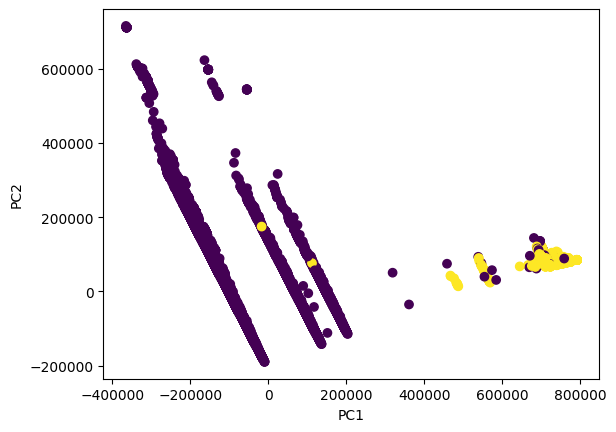

In [67]:
import matplotlib.pyplot as plt

plt.scatter(data_pca_10[:, 0], data_pca_10[:, 1], c=cluster_assignments)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

In [68]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data)

/Users/alechh/PythonProjects/machine-learning-course/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/alechh/PythonProjects/machine-learning-course/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


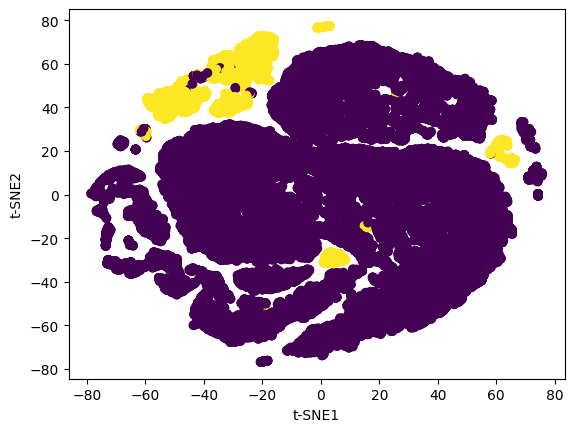

In [70]:
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=cluster_assignments)
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

plt.show()